# Purpose
* The purpose of this notebook is to show an example of traning, testing, and hypertuning a random forest model on ANLY499 Case Study 9 data.
---
### Brandon Johnson

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp 

from sklearn.ensemble import RandomForestRegressor # Random Forest Algo
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Seed

In [5]:
seed = 77 # for reproducibility so that random numbers are generated the same way

# Data

In [2]:
df1 = pd.read_csv('Part1_Case Study _9.csv')
df1.head()

,Price,Acres,Years Old,DoM
0,330.0,0.23,4,127
1,400.0,0.17,5,98
2,416.0,0.18,16,105
3,420.0,0.29,80,103
4,496.0,0.52,9,39


In [3]:
# Checking the number of observations and their data types.  For ML, we need all data types to be numeric
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      45 non-null     float64
 1   Acres      45 non-null     float64
 2   Years Old  45 non-null     int64  
 3   DoM        45 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 1.5 KB


# Splitting the data into train and test sets

In [7]:
X = df1.drop('Price',axis=1) # a dataframe for all the regressor variables
y = df1.Price # a dataframe for the regressand variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed) 
# the test size is only 10% of the data since the data set is small which leave 90% of the data for training

print(f'X Train shape: {X_train.shape}') # (rows, columns)
print(f'y Train shape: {y_train.shape}') # (rows, columns)
print(f'X Test shape: {X_test.shape}') # (rows, columns)
print(f'y Test shape: {y_test.shape}') # (rows, columns)

X Train shape: (40, 3)
y Train shape: (40,)
X Test shape: (5, 3)
y Test shape: (5,)


# Random Forest Training
* No hypertuning is done here

In [15]:
# creating the algorithm object
rfr = RandomForestRegressor( # these are all hyperparameters
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1, # allows all of your processing cores to be used
    random_state=seed, 
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)


rfr.fit(X_train, y_train) # training the model with the training data

RandomForestRegressor(n_jobs=-1, random_state=77)

# Scoring the trained model on the data it was trained with

In [16]:
y_pred_train = rfr.predict(X_train)

train_r2 = r2_score(y_true=y_train, y_pred=y_pred_train)
print(f'Training R2 score: {train_r2:.4f}')

train_rmse = mean_squared_error(y_true=y_train, y_pred=y_pred_train, squared=False) # squared=False turns MSE into RMSE
print(f'Training RMSE: {train_rmse:.4f}')

Training R2 score: 0.8373
Training RMSE: 53.7952


# Important Regressors

In [22]:
def feature_importance(model,x):
    importance = model.feature_importances_ # important regressors as the random forest see it
    regressors = X.columns
    plt.figure(dpi=150)
    sns.barplot(x=regressors, y=importance)
    plt.xlabel('Regressors')
    plt.ylabel('Importance')

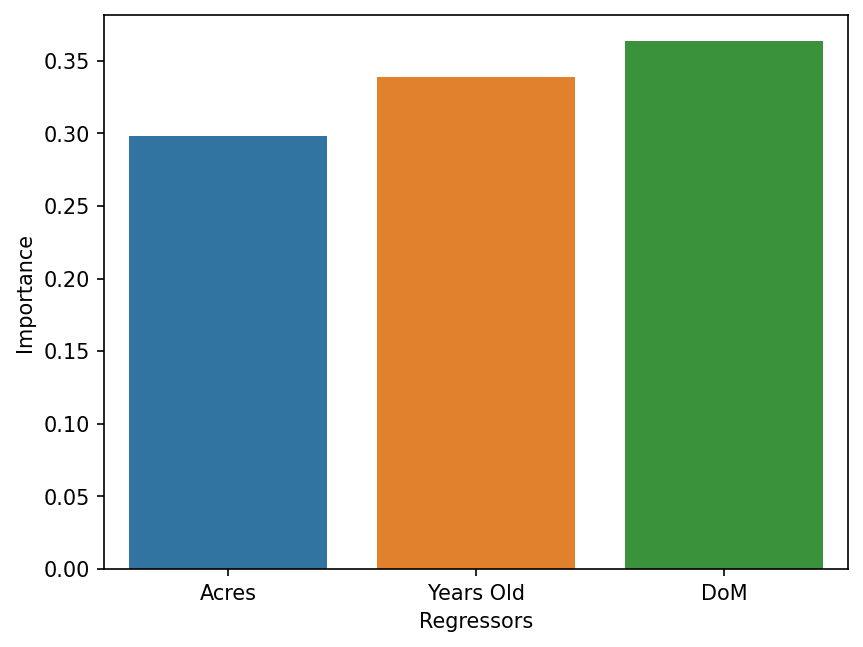

In [23]:
feature_importance(rfr,x=X)

# Scoring the trained model on the test data that it has never seen before

In [25]:
y_pred_test = rfr.predict(X_test)

test_r2 = r2_score(y_true=y_test, y_pred=y_pred_test)
print(f'Test R2 score: {test_r2:.4f}')

test_rmse = mean_squared_error(y_true=y_test, y_pred=y_pred_test, squared=False) # squared=False turns MSE into RMSE
print(f'Test RMSE: {test_rmse:.4f}')
print(f'The model did not perform well on testing data, BUT it performed better than MLR')
print('Recall the MLR scores were: R2 of 0.126 and an RMSE of 122.57')

Test R2 score: 0.2540
Test RMSE: 67.2602
The model did not perform well on testing data, BUT it performed better than MLR
Recall the MLR scores were: R2 of 0.126 and an RMSE of 122.57


# Random Forest hypertuning and training the model
* Neg RMSE is the metric being used for the optimization metric.
* It has to be a negative because of the way the optimization algorithm works. The algorithm is designed to maximize a metric and RMSE is not something you want to maximize.  So, maximizing a negative RMSE is the same as minimizing RMSE. 
* Other scoring metrics here: https://scikit-learn.org/stable/modules/model_evaluation.html

In [45]:
%%time 
# times how long this tuning process takes

# creating the algorithm object
rfr = RandomForestRegressor(
    criterion='squared_error',
    n_jobs=-1, # allows all of your processing cores to be used
    random_state=seed, 
)


params = dict( # only going to tune a few hyperparameters because the dataset is small
    n_estimators = sp.stats.randint(100, 500-100),
    max_depth = [None,1,2,3,4,5],
    max_features = sp.stats.uniform(0.25, 1-0.5),
)

rand_search = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=params, # the params to randomly select during cross-validation training
    n_iter=200, # number of time to randomly test different parameteres.  The larger the longer it takes to tune.
    scoring='neg_root_mean_squared_error', # has to be a negative because the way the optimization algorithm works.  Other scoring metrics here: https://scikit-learn.org/stable/modules/model_evaluation.html
    n_jobs=-1,
    refit=True,
    cv=3, # number of folds in the cross-validation.   The larger the longer it takes to tune.
    random_state=seed,
)




rand_search.fit(X_train, y_train) # hypertuning and training the model

print(f'Best Params: {rand_search.best_params_}')
print(f'Best RMSE: {-1*rand_search.best_score_:.4f}')

Best Params: {'max_depth': 1, 'max_features': 0.6892413819508358, 'n_estimators': 195}
Best RMSE: 128.8171
CPU times: total: 1.55 s
Wall time: 31.8 s


# Training the model with the selected hyperparams

In [50]:
rfr = RandomForestRegressor(**rand_search.best_params_, # unpacking a the best hyperparameter dictionary of the best hyperparameters to a new Random Forest object
                            n_jobs=-1, 
                            random_state=seed) 

rfr.fit(X_train,y_train)

y_pred_train2 = rfr.predict(X_train)

train_r2_2 = r2_score(y_true=y_train, y_pred=y_pred_train2)
print(f'Training R2 score: {train_r2_2:.4f}')

train_rmse_2 = mean_squared_error(y_true=y_train, y_pred=y_pred_train2, squared=False) # squared=False turns MSE into RMSE
print(f'Training RMSE: {train_rmse_2:.4f}')

Training R2 score: 0.2094
Training RMSE: 118.5890


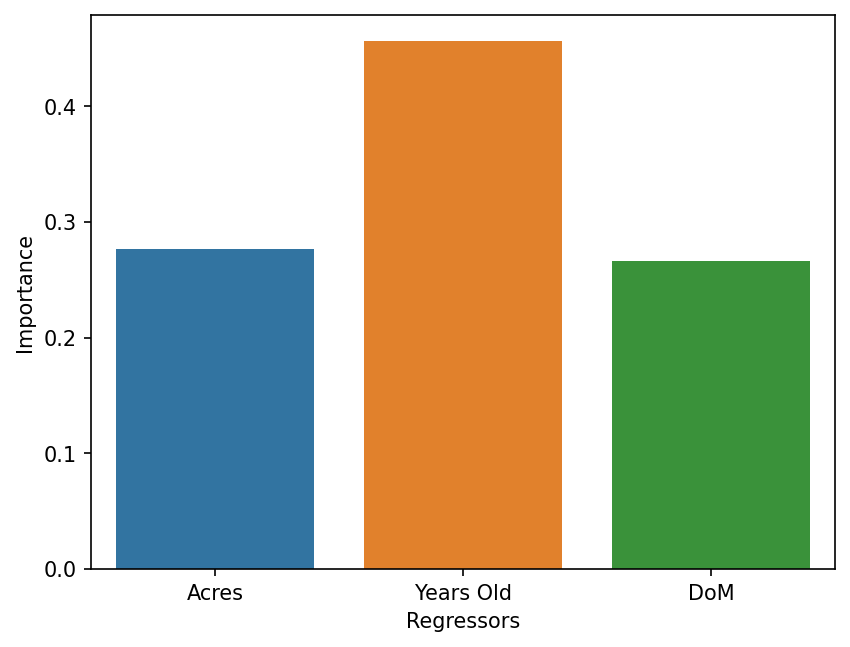

In [51]:
feature_importance(rfr,x=X)

# Scoring the trained model on the test data that it has never seen before

In [52]:
y_pred_test_2 = rfr.predict(X_test)

test_r2_2 = r2_score(y_true=y_test, y_pred=y_pred_test_2)
print(f'Test R2 score: {test_r2_2:.4f}')

test_rmse_2 = mean_squared_error(y_true=y_test, y_pred=y_pred_test_2, squared=False) # squared=False turns MSE into RMSE
print(f'Test RMSE: {test_rmse_2:.4f}')
print(f'The model did not perform well on testing data, but for some reason its RMSE is low and yet has a negative R2')
print('Recall the MLR scores were: R2 of 0.126 and an RMSE of 122.57')

Test R2 score: -0.5331
Test RMSE: 96.4181
The model did not perform well on testing data, but for some reason its RMSE is low and yet has a negative R2
Recall the MLR scores were: R2 of 0.126 and an RMSE of 122.57


# Notes
* There is not enough data to use Random Forest.
* It does not matter how much one could attempt to hypertune the model, it simply needs more data.